In [103]:
import pandas as pd
import numpy as np 
import lightgbm as lgb
from scipy.stats import skew
import optuna 
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from optuna.integration import LightGBMPruningCallback
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [105]:
SEED = 42 

def rmlse(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

## My best models

In [106]:
all_data = pd.read_csv('all_data_h2.csv')

NUMERIC_FEATURES = ["latitude", "longitude", "constructed", "log_area_total", "log_area_per_room", "rooms", "metro_distance", "park_distance",
            "square_distance", "metro_close", "park_close", "square_close", "stories", "floor", "ceiling_fix", "bathrooms_total", "ballog", "distr_avg", 
            'khamo_dist', 'ostoz_dist', 'rublevka_dist', 'yaki_dist', 'arbat_dist', 'pres_dist', 'tver_dist']
            
CATEGORICAL_FEATURES = ['condition', 'district', 'garbage_chute', 'heating', 'layout', 'material',
                         'new', 'parking', 'seller', 'windows_court', 'windows_street']
            
all_data[CATEGORICAL_FEATURES] = all_data[CATEGORICAL_FEATURES].astype('category')

# fix floor and make category


data = all_data.loc[all_data['split'] == 'train', :]
data_test = all_data.loc[all_data['split'] == 'test', :]

In [108]:
# fix floor and make category
floor_idx = all_data.floor > all_data.stories
all_data.loc[floor_idx, 'floor'] = all_data.loc[floor_idx, 'stories']

In [109]:
X = data[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = data.price
area = data.area_total

STORAGE = "sqlite:///jim_optuna.sqlite"
lgb_h2_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name="LightGBM-h2",
    direction="minimize",
    load_if_exists=True
)

[I 2021-11-16 18:12:33,261] Using an existing study with name 'LightGBM-h2' instead of creating a new one.


In [110]:
lgb_h2_mod = lgb.LGBMRegressor(random_state=SEED, metric="rmse", n_jobs=3, n_estimators=6000, **lgb_h2_study.best_params)
lgb_h2_mod.fit(X, np.log(y/area))

LGBMRegressor(boosting_type='gbdt', cat_smooth=8, class_weight=None,
              colsample_bytree=0.4, importance_type='split',
              learning_rate=0.006, max_depth=32, metric='rmse',
              min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=6000, n_jobs=3, num_leaves=327, objective=None,
              random_state=42, reg_alpha=0.04332781805200478,
              reg_lambda=0.02011247431970239, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

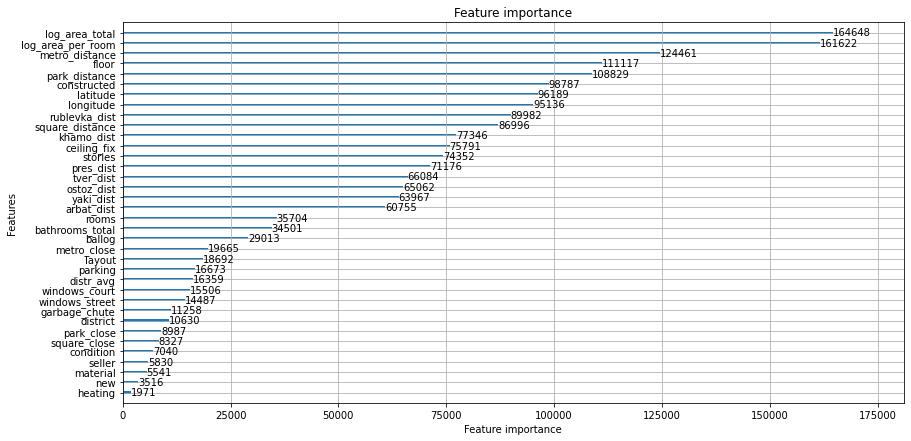

In [111]:
plt.rcParams["figure.figsize"] = (14, 7)
lgb.plot_importance(lgb_h2_mod)

In [113]:
X_test = data_test[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
lgb_h2_preds = np.exp(lgb_h2_mod.predict(X_test)) * data_test.area_total

In [54]:
X = data[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = data.price
area = data.area_total

STORAGE = "sqlite:///jim_optuna.sqlite"
lgb_lh_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name="LightGBM-lh",
    direction="minimize",
    load_if_exists=True
)

[I 2021-11-16 14:19:35,398] Using an existing study with name 'LightGBM-lh' instead of creating a new one.


In [60]:
lgb_lh_mod = lgb.LGBMRegressor(random_state=SEED, metric="rmse", n_jobs=3, n_estimators=6000, **lgb_lh_study.best_params)
lgb_lh_mod.fit(X, np.log(y))

LGBMRegressor(boosting_type='gbdt', cat_smooth=7, class_weight=None,
              colsample_bytree=0.3, importance_type='split',
              learning_rate=0.014, max_depth=190, metric='rmse',
              min_child_samples=51, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=6000, n_jobs=3, num_leaves=577, objective=None,
              random_state=42, reg_alpha=0.014271524753120282,
              reg_lambda=2.617733554654722, silent=True, subsample=0.7,
              subsample_for_bin=200000, subsample_freq=0)

In [61]:
X_test = data_test[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
lgb_lh_preds = np.exp(lgb_lh_mod.predict(X_test))

In [114]:
from catboost import CatBoostRegressor

STORAGE = "sqlite:///jim_optuna.sqlite"
cat_lh_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name="cat-lh",
    direction="minimize",
    load_if_exists=True
)
all_data = pd.read_csv('all_data_h2.csv')
all_data['district'] = all_data['district'].astype(int)
data = all_data.loc[all_data['split'] == 'train', :]
data_test = all_data.loc[all_data['split'] == 'test', :]

X = data[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = data.price
area = data.area_total

cat_lh_mod = CatBoostRegressor(objective="RMSE", random_seed=SEED, silent=True, thread_count=4, **cat_lh_study.best_params)
cat_lh_mod.fit(X, np.log(y/area), cat_features = ['district'])

[I 2021-11-16 18:15:28,652] Using an existing study with name 'cat-lh' instead of creating a new one.


In [115]:
X_test = data_test[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
cat_lh_preds = np.exp(cat_lh_mod.predict(X_test)) * data_test.area_total

## Vegards best models

In [117]:
LIGHTGBM_F4LC_FEATURES = [
    "latitude", "longitude", "district", "constructed", "log_area_total",
    "rooms", "ballog", "metro_distance", "park_distance", "square_distance",
    "material", "condition", "heating", "stories", "floor", "ceiling_fix",
    "bathrooms_total", "new",
]
LIGHTGBM_F4LC_CATEGORICAL_FEATURES = [
    "district", "material", "condition", "heating", "new",
]

STORAGE = 'sqlite:///vegard_optuna.sqlite'

lgb_f4lc_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name="LightGBM-F4LC",
    direction="minimize",
    load_if_exists=True
)

# Load data and create ceiling_fixed
vegard_data = pd.read_csv('resources/vegard_preprocessed.csv')
idx = vegard_data.ceiling > 50
vegard_data["ceiling_fix"] = vegard_data.ceiling
vegard_data.loc[idx, "ceiling_fix"] = vegard_data.ceiling[idx] / 100

v_data = vegard_data.loc[vegard_data.split == 'train']
v_data_test = vegard_data.loc[vegard_data.split == 'test']

lgb_f4lc_model = lgb.LGBMRegressor(metric="rmse", n_estimators=5000, random_state=SEED, **lgb_f4lc_study.best_params)
lgb_f4lc_model.fit(v_data[LIGHTGBM_F4LC_FEATURES], np.log(v_data.price/area))

[I 2021-11-16 18:18:03,516] Using an existing study with name 'LightGBM-F4LC' instead of creating a new one.


LGBMRegressor(boosting_type='gbdt', cat_smooth=56, class_weight=None,
              colsample_bytree=0.6, importance_type='split', learning_rate=0.03,
              max_depth=121, metric='rmse', min_child_samples=1,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
              n_jobs=-1, num_leaves=515, objective=None, random_state=42,
              reg_alpha=0.13020331134351731, reg_lambda=1.2937692395596345,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [118]:
X_test = v_data_test[LIGHTGBM_F4LC_FEATURES]
lgb_f4lc_preds = np.exp(lgb_f4lc_model.predict(X_test)) * data_test.area_total

In [119]:
CATBOOST_T2LC_FEATURES = LIGHTGBM_F4LC_FEATURES

cat_t2lc_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="CatBoost-T2LC",
    direction="minimize",
    load_if_exists=True
)

cat_t2lc_mod = CatBoostRegressor(objective="RMSE", random_seed=SEED, silent=True, thread_count=1, **cat_t2lc_study.best_params)
cat_t2lc_mod.fit(v_data[LIGHTGBM_F4LC_FEATURES],  np.log(v_data.price/area))

[I 2021-11-16 18:18:42,243] Using an existing study with name 'CatBoost-T2LC' instead of creating a new one.


In [120]:
X_test = v_data_test[CATBOOST_T2LC_FEATURES]
cat_t2lc_preds = np.exp(cat_t2lc_mod.predict(X_test)) * v_data_test.area_total

## Combining models

In [121]:
final_preds = np.average(
        [ lgb_h2_preds, cat_lh_preds, lgb_f4lc_preds, cat_t2lc_preds],
        axis=0,
        weights=[-lgb_h2_study.best_value, -cat_lh_study.best_value, -lgb_f4lc_study.best_value, -cat_t2lc_study.best_value],
    )
submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = final_preds
submission.to_csv('submissions/combo.csv', index=False)

In [122]:
submission

,id,price_prediction
0,23285,3.048068e+07
1,23286,9.846508e+06
2,23287,6.115501e+06
3,23288,8.331167e+06
4,23289,5.354620e+06
...,...,...
9932,33217,2.937221e+07
9933,33218,1.953815e+07
9934,33219,8.959680e+06
9935,33220,8.967027e+06


In [73]:
submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = lgb_lh_preds
submission.to_csv('submissions/lgb_lh.csv', index=False)

In [102]:
pd.DataFrame.from_dict({
    "Number of completed trials": (lgb_h2_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": lgb_h2_study.best_trial.number,
    "Best value": lgb_h2_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,164.000000
Best trial,164.000000
Best value,0.115934
